In [53]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker

In [5]:
# get root dir which ends in repo_name
repo_name = 'Fed_IT_Employment'
root = os.getcwd()
while os.path.basename(root) != repo_name:
    root = os.path.dirname(root)

# Get raw data directory
rdir = os.path.join( root, 'data', 'raw_data')

print(f"Base directory: {root}\nRaw data directory: {rdir}")

Base directory: /Users/coltonlapp/Dropbox/My Mac (Coltons-MacBook-Pro.local)/Desktop/Work/USDC/publicwork/Fed_IT_Employment
Raw data directory: /Users/coltonlapp/Dropbox/My Mac (Coltons-MacBook-Pro.local)/Desktop/Work/USDC/publicwork/Fed_IT_Employment/data/raw_data


In [6]:
 # Read in processed ACS data

ACS = pd.read_csv(os.path.join(root, 'data', 'processed_data', 'IPUMS', 'IPUMS_usa_v2_extract5.csv'))

ACS.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STRATA,GQ,STATEFIP,PERNUM,...,RACE,RACED,EDUC,EDUCD,OCC2010,INDNAICS,INCTOT,DISABWRK,SPMPOV,OFFPOV
0,2005,200501,2.0,190.0,51,2005000000021,90101,1,1,1,...,2,200,6,62,5620,45211,12000.0,1.0,NaN,NaN
1,2005,200501,2.0,190.0,51,2005000000021,90101,1,1,2,...,2,200,2,21,9920,0,9999999.0,0.0,NaN,NaN
2,2005,200501,2.0,190.0,51,2005000000021,90101,1,1,3,...,2,200,2,21,9920,0,9999999.0,0.0,NaN,NaN
3,2005,200501,3.0,204.0,20,2005000000031,250001,1,1,1,...,1,100,4,40,4720,722Z,8800.0,1.0,NaN,NaN
4,2005,200501,3.0,204.0,20,2005000000031,250001,1,1,2,...,1,100,6,62,6260,23,9000.0,1.0,NaN,NaN


In [18]:
# Filter for IT workers

# 1000                Computer Scientists and Systems Analysts/Network systems Analysts/Web Developers
# 1010                Computer Programmers
# 1020                Software Developers, Applications and Systems Software
# 1050                Computer Support Specialists
# 1060                Database Administrators
# 1100                Network and Computer Systems Administrators
# 1200                Actuaries
# 1220                Operations Research Analysts
# 1230                Statisticians
# 1240                Mathematical science occupations, nec

IT_codes = [1000, 1010, 1020, 1050, 1060, 1100, 1200, 1220, 1230, 1240]
IT_codes = [1000]

IT = ACS[ACS['OCC2010'].isin(IT_codes)]

# Recode missing values 
# AGE
# 999                 Missing

IT.loc[:, 'AGE'] = IT['AGE'].replace(999, None)



In [19]:
# Drop where age is missing
IT = IT.dropna(subset=['AGE'])

# Sum stats of age
IT['AGE'].describe()


count    55042.000000
mean        42.443262
std         12.941376
min         16.000000
25%         32.000000
50%         42.000000
75%         52.000000
max         95.000000
Name: AGE, dtype: float64

In [20]:
# Create a new column for age group
IT['AGE_GROUP'] = pd.cut(IT['AGE'], bins=[0, 30, 60, 100], labels=['<30', '30-60', '>60'], right=False)

# Group by year and age group, aggregating the sum of PERWT (weights)
IT_age = IT.groupby(['YEAR', 'AGE_GROUP'], as_index=False).agg({'PERWT': 'sum'})

# Calculate weighted percentage for each age group within each year
IT_age['PERCENTAGE'] = IT_age.groupby('YEAR')['PERWT'].transform(lambda x: 100 * x / x.sum())

# Pivot the table to have age groups as columns
IT_age_pivot = IT_age.pivot(index='YEAR', columns='AGE_GROUP', values='PERCENTAGE').reset_index()

# Rename the age group columns to more descriptive labels
IT_age_pivot.columns = ['YEAR', '<30', '30-60', '>60']

# Display the resulting pivot table
IT_age_pivot

,YEAR,<30,30-60,>60
0,2005,20.643057,74.025956,5.330987
1,2010,19.265500,73.168732,7.565768
2,2015,19.564172,70.661819,9.774009
3,2020,20.636002,67.069895,12.294103


In [24]:
# Also calculate the total of PERWT for each year
IT_total = IT_age.groupby('YEAR', as_index=False).agg({'PERWT': 'sum'})

# rename PERWT to TOTAL_EMPLOYMENT
IT_total = IT_total.rename(columns={'PERWT': 'TOTAL_EMPLOYMENT'})

IT_total

,YEAR,TOTAL_EMPLOYMENT
0,2005,1150256
1,2010,1244302
2,2015,1640555
3,2020,2042101


In [25]:
# Merge the total PERWT with the age group pivot table
IT_age_pivot = pd.merge(IT_age_pivot, IT_total, on='YEAR')
IT_age_pivot

,YEAR,<30,30-60,>60,PERWT,TOTAL_EMPLOYMENT
0,2005,20.643057,74.025956,5.330987,1150256,1150256
1,2010,19.265500,73.168732,7.565768,1244302,1244302
2,2015,19.564172,70.661819,9.774009,1640555,1640555
3,2020,20.636002,67.069895,12.294103,2042101,2042101


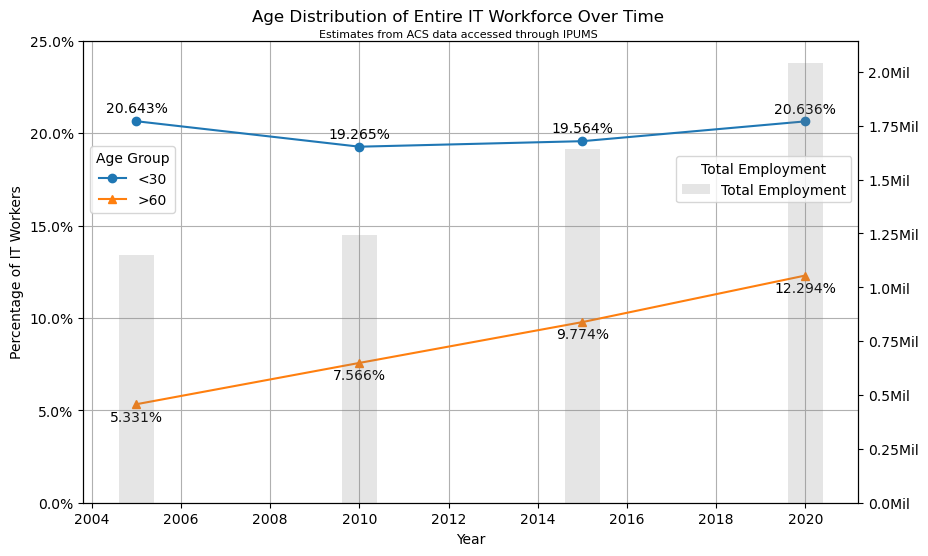

In [68]:
# Graph the percentage of IT workers in each age group over time

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the percentage of IT workers in each age group over time
# Plot the percentage of IT workers in each age group with linestyle and markers
ax.plot(IT_age_pivot['YEAR'], IT_age_pivot['<30'], label='<30', linestyle='-', marker='o')
#ax.plot(IT_age_pivot['YEAR'], IT_age_pivot['30-60'], label='30-60', linestyle='--', marker='s')
ax.plot(IT_age_pivot['YEAR'], IT_age_pivot['>60'], label='>60', linestyle='-', marker='^')


# Add percentage labels above each point for '<30'
for i, val in enumerate(IT_age_pivot['<30']):
    ax.text(IT_age_pivot['YEAR'][i], val+ .3, f'{val:.3f}%', ha='center', va='bottom', fontsize=10)

# Add percentage labels above each point for '>60'
for i, val in enumerate(IT_age_pivot['>60']):
    ax.text(IT_age_pivot['YEAR'][i], val-.3, f'{val:.3f}%', ha='center', va='top', fontsize=10)
    

ax2 = ax.twinx()
ax2.bar(IT_age_pivot['YEAR'], IT_age_pivot['TOTAL_EMPLOYMENT'], color='gray', alpha=0.2, label='Total Employment')

# Format the right y-axis to display values in thousands (e.g., 100K, 200K)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{round(x/1000000, 3):,}Mil'))


# Add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Percentage of IT Workers')

# Add a grid
ax.grid(True)

# Add a y-axis percentage formatter
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Add legends for both axes
# Adjust the location of the legends to the middle
ax.legend(title='Age Group', loc='center left', bbox_to_anchor=(0, 0.7))  # Age group legend
ax2.legend(title='Total Employment', loc='center right', bbox_to_anchor=(1, 0.7))  # Total employment legend

# Subtitle saying it's based on ACS data and from IPUMS
# Adjusting subtitle to be below the title
# Add subtitle saying it's based on ACS data and from IPUMS
fig.text(0.5, 0.92, 'Age Distribution of Entire IT Workforce Over Time', ha='center', va='center', fontsize=12)
fig.text(0.5, 0.89, 'Estimates from ACS data accessed through IPUMS', ha='center', va='center', fontsize=8)

# y limit to 25
ax.set_ylim(0, 25)

# Display the plot
plt.show()


